# Embedding large data sets

Embedding large data sets typically requires more care. Using various tricks described in *preserving_global_structure* can become quite slow to run. Instead, we can take a smaller, manageable sample of our data set, obtain a good visualization of that. Then, we can add the remaining points to the embedding and use that as our initialization.

Remember that the initialization largely affects the structure of the embedding. This way, our initialization provides the global structure for the embedding, and the subsequent optimization can focus on preserving local strucutre.

In [1]:
from openTSNE import TSNE, TSNEEmbedding, affinity, initialization
from openTSNE import initialization
from openTSNE.callbacks import ErrorLogger

from examples import utils

import numpy as np

import matplotlib.pyplot as plt

## Load data

In [2]:
import gzip
import pickle

with gzip.open("data/10x_mouse_zheng.pkl.gz", "rb") as f:
    data = pickle.load(f)

x = data["pca_50"]
y = data["CellType1"]

In [3]:
print("Data set contains %d samples with %d features" % x.shape)

Data set contains 1306127 samples with 50 features


In [4]:
def plot(x, y, **kwargs):
    utils.plot(
        x,
        y,
        colors=utils.MOUSE_10X_COLORS,
        alpha=kwargs.pop("alpha", 0.1),
        draw_legend=False,
        **kwargs,
    )

In [5]:
def rotate(degrees):
    phi = degrees * np.pi / 180
    return np.array([
        [np.cos(phi), -np.sin(phi)],
        [np.sin(phi), np.cos(phi)],
    ])

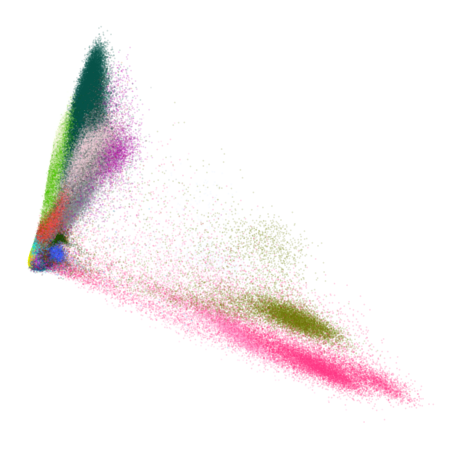

In [6]:
plot(x, y)

We'll also precompute the full affinities, since we'll be needing it in several places throughout the notebook, and can take a long time to run.

In [7]:
%%time
affinities = affinity.PerplexityBasedNN(
    x,
    perplexity=30,
    n_jobs=8,
    random_state=0,
)

CPU times: user 1h 2min 57s, sys: 1min 47s, total: 1h 4min 44s
Wall time: 37min 40s


## Standard t-SNE

First, let's see what standard t-SNE does.

In [8]:
%time init = initialization.pca(x, random_state=0)

CPU times: user 2min 46s, sys: 8.71 s, total: 2min 54s
Wall time: 5.27 s


In [9]:
embedding_standard = TSNEEmbedding(
    init,
    affinities,
    negative_gradient_method="fft",
    n_jobs=8,
)

In [10]:
%%time
embedding_standard.optimize(n_iter=250, exaggeration=12, momentum=0.5, inplace=True)
embedding_standard.optimize(n_iter=750, exaggeration=1, momentum=0.8, inplace=True)

CPU times: user 4h 22min 22s, sys: 5min 47s, total: 4h 28min 10s
Wall time: 16min 1s


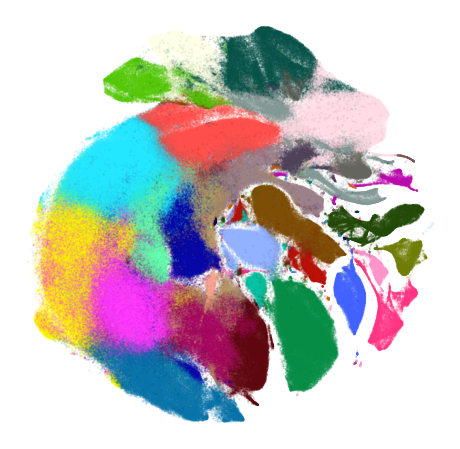

In [11]:
plot(embedding_standard, y)

This doesn't look too great. The cluster separation is quite poor and the visualization is visually not very appealing.

## Using exaggeration

Exaggeration can be used in order to get better separation between clusters. Let's see if that helps.

In [12]:
%time init = initialization.pca(x, random_state=0)

CPU times: user 2min 47s, sys: 7.07 s, total: 2min 54s
Wall time: 5.55 s


In [13]:
embedding_exag = TSNEEmbedding(
    init,
    affinities,
    negative_gradient_method="fft",
    n_jobs=8,
)

In [14]:
%%time
embedding_exag.optimize(n_iter=250, exaggeration=12, momentum=0.5, inplace=True)
embedding_exag.optimize(n_iter=750, exaggeration=4, momentum=0.8, inplace=True)

CPU times: user 4h 19min 6s, sys: 4min 51s, total: 4h 23min 57s
Wall time: 15min 38s


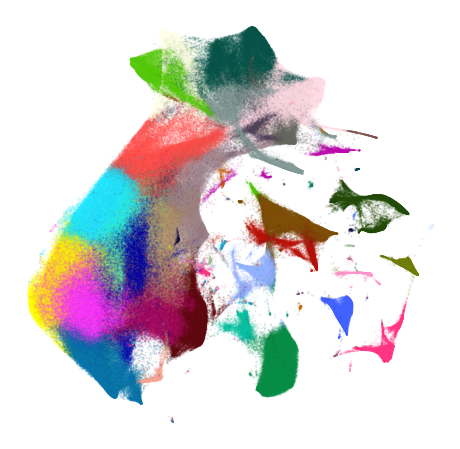

In [15]:
plot(embedding_exag, y)

The separation has improved quite a bit, but many clusters are still intertwined with others.

## With downsampling

We now perform the sample-transform trick we described above.

### Create train/test split

In [16]:
np.random.seed(0)

In [17]:
indices = np.random.permutation(list(range(x.shape[0])))
reverse = np.argsort(indices)

x_sample, x_rest = x[indices[:25000]], x[indices[25000:]]
y_sample, y_rest = y[indices[:25000]], y[indices[25000:]]

### Create sample embedding

In [18]:
%%time
sample_affinities = affinity.PerplexityBasedNN(
    x_sample,
    perplexity=500,
    method="approx",
    n_jobs=8,
    random_state=0,
)

CPU times: user 9min 18s, sys: 6.92 s, total: 9min 25s
Wall time: 2min 1s


In [19]:
%time sample_init = initialization.pca(x_sample, random_state=42)

CPU times: user 2.33 s, sys: 90.3 ms, total: 2.42 s
Wall time: 62.2 ms


In [20]:
sample_embedding = TSNEEmbedding(
    sample_init,
    sample_affinities,
    negative_gradient_method="fft",
    n_jobs=8,
    callbacks=ErrorLogger(),
)

In [21]:
%time sample_embedding1 = sample_embedding.optimize(n_iter=250, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  3.1703, 50 iterations in 5.7042 sec
Iteration  100, KL divergence  3.0518, 50 iterations in 6.0842 sec
Iteration  150, KL divergence  3.0461, 50 iterations in 5.6341 sec
Iteration  200, KL divergence  3.0447, 50 iterations in 6.5530 sec
Iteration  250, KL divergence  3.0441, 50 iterations in 5.5155 sec
CPU times: user 12min, sys: 10 s, total: 12min 10s
Wall time: 29.9 s


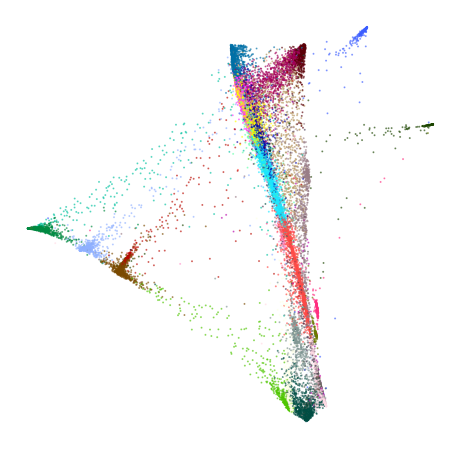

In [22]:
plot(sample_embedding1, y[indices[:25000]], alpha=0.5)

In [23]:
%time sample_embedding2 = sample_embedding1.optimize(n_iter=750, exaggeration=1, momentum=0.8)

Iteration   50, KL divergence  1.5264, 50 iterations in 6.6760 sec
Iteration  100, KL divergence  1.3347, 50 iterations in 6.5701 sec
Iteration  150, KL divergence  1.2537, 50 iterations in 5.7738 sec
Iteration  200, KL divergence  1.2109, 50 iterations in 6.0972 sec
Iteration  250, KL divergence  1.1856, 50 iterations in 6.1227 sec
Iteration  300, KL divergence  1.1694, 50 iterations in 5.8382 sec
Iteration  350, KL divergence  1.1599, 50 iterations in 6.1803 sec
Iteration  400, KL divergence  1.1536, 50 iterations in 5.6595 sec
Iteration  450, KL divergence  1.1500, 50 iterations in 6.1716 sec
Iteration  500, KL divergence  1.1465, 50 iterations in 6.5309 sec
Iteration  550, KL divergence  1.1440, 50 iterations in 6.5737 sec
Iteration  600, KL divergence  1.1418, 50 iterations in 6.4968 sec
Iteration  650, KL divergence  1.1402, 50 iterations in 5.2163 sec
Iteration  700, KL divergence  1.1388, 50 iterations in 5.6052 sec
Iteration  750, KL divergence  1.1373, 50 iterations in 6.2774

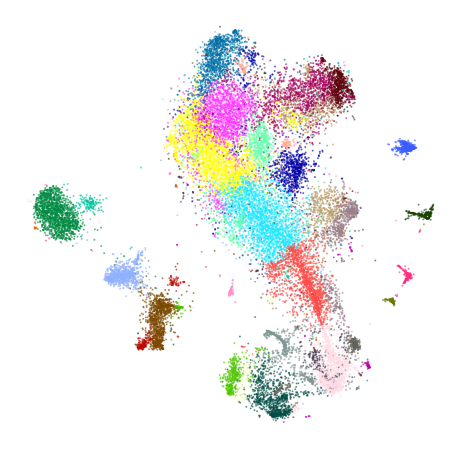

In [24]:
plot(sample_embedding2, y[indices[:25000]], alpha=0.5)

### Learn the full embedding

In [25]:
%time rest_init = sample_embedding2.prepare_partial(x_rest, k=1, perplexity=1/3)

CPU times: user 2min 37s, sys: 652 ms, total: 2min 38s
Wall time: 1min 18s


In [26]:
init_full = np.vstack((sample_embedding2, rest_init))[reverse]

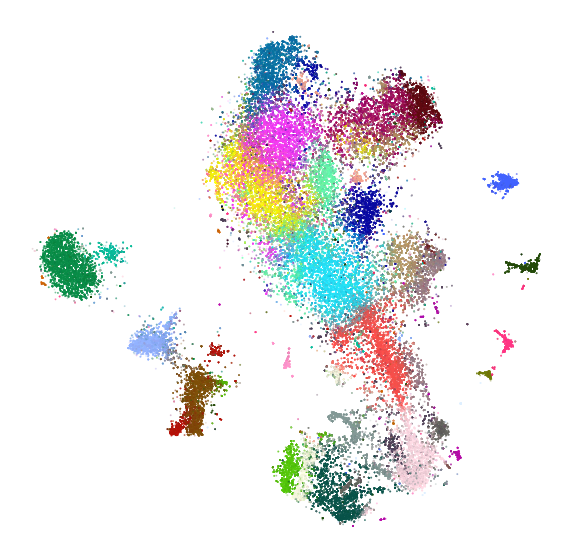

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
plot(init_full, y, ax=ax)

In [28]:
init_full = init_full / (np.std(init_full[:, 0]) * 10000)
np.std(init_full, axis=0)

array([1.00000000e-04, 1.14353061e-04])

In [29]:
embedding = TSNEEmbedding(
    init_full,
    affinities,
    learning_rate=1000,
    negative_gradient_method="fft",
    n_jobs=8,
    callbacks=ErrorLogger(),
    random_state=42,
)

In [30]:
%time embedding1 = embedding.optimize(n_iter=500, exaggeration=12, momentum=0.5)

Iteration   50, KL divergence  10.2843, 50 iterations in 48.5307 sec
Iteration  100, KL divergence  10.2803, 50 iterations in 48.2069 sec
Iteration  150, KL divergence  9.3181, 50 iterations in 47.9606 sec
Iteration  200, KL divergence  8.7442, 50 iterations in 48.3420 sec
Iteration  250, KL divergence  8.5049, 50 iterations in 48.1888 sec
Iteration  300, KL divergence  8.3797, 50 iterations in 48.1925 sec
Iteration  350, KL divergence  8.3061, 50 iterations in 48.5544 sec
Iteration  400, KL divergence  8.2591, 50 iterations in 48.4718 sec
Iteration  450, KL divergence  8.2273, 50 iterations in 48.4514 sec
Iteration  500, KL divergence  8.2049, 50 iterations in 48.4425 sec
CPU times: user 2h 15min 27s, sys: 2min 28s, total: 2h 17min 56s
Wall time: 8min 5s


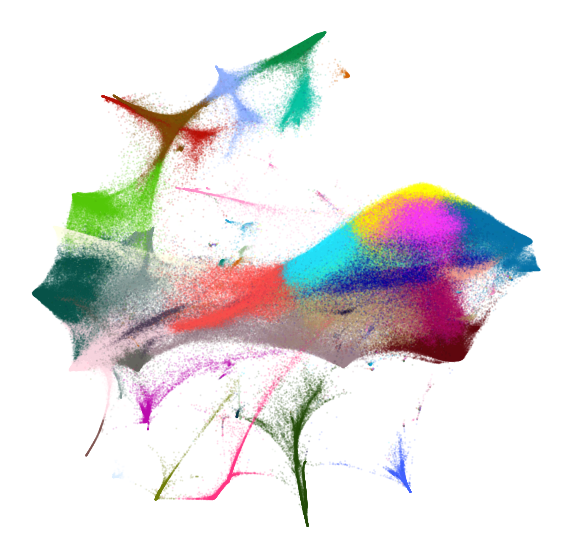

In [31]:
fig, ax = plt.subplots(figsize=(10, 10))
plot(embedding1 @ rotate(90), y, ax=ax)

In [32]:
%time embedding2 = embedding1.optimize(n_iter=250, exaggeration=4, momentum=0.8)

Iteration   50, KL divergence  7.6311, 50 iterations in 54.7087 sec
Iteration  100, KL divergence  7.4543, 50 iterations in 48.5959 sec
Iteration  150, KL divergence  7.3482, 50 iterations in 48.6267 sec
Iteration  200, KL divergence  7.2778, 50 iterations in 48.8663 sec
Iteration  250, KL divergence  7.2278, 50 iterations in 48.9803 sec
CPU times: user 1h 7min 26s, sys: 1min 16s, total: 1h 8min 43s
Wall time: 4min 12s


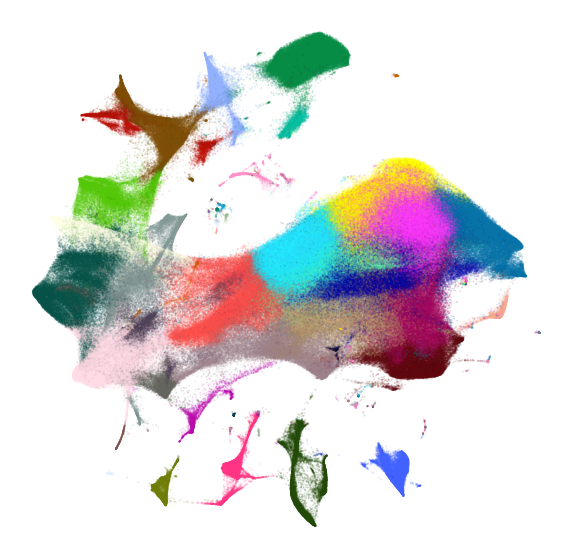

In [33]:
fig, ax = plt.subplots(figsize=(10, 10))
plot(embedding2 @ rotate(90), y, ax=ax)

In [34]:
%time embedding3 = embedding2.optimize(n_iter=250, exaggeration=4, momentum=0.8)

Iteration   50, KL divergence  7.1927, 50 iterations in 47.5765 sec
Iteration  100, KL divergence  7.1623, 50 iterations in 47.2527 sec
Iteration  150, KL divergence  7.1375, 50 iterations in 47.1718 sec
Iteration  200, KL divergence  7.1169, 50 iterations in 47.1572 sec
Iteration  250, KL divergence  7.0995, 50 iterations in 47.5738 sec
CPU times: user 1h 6min 21s, sys: 1min 12s, total: 1h 7min 33s
Wall time: 3min 59s


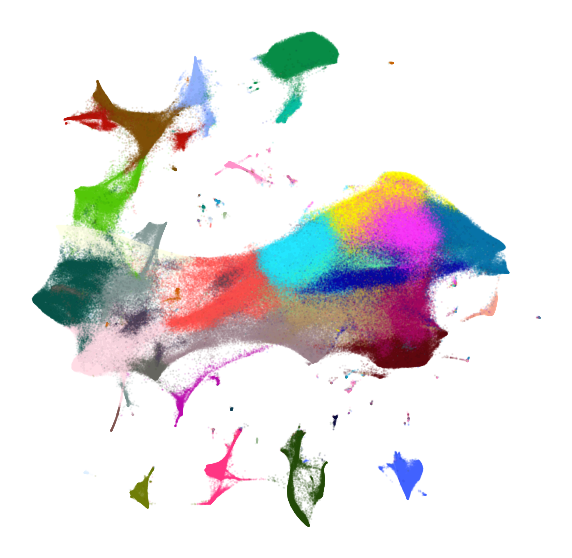

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))
plot(embedding3 @ rotate(90), y, ax=ax)

In [36]:
%time embedding4 = embedding3.optimize(n_iter=250, exaggeration=4, momentum=0.8)

Iteration   50, KL divergence  7.0854, 50 iterations in 47.2708 sec
Iteration  100, KL divergence  7.0716, 50 iterations in 47.4487 sec
Iteration  150, KL divergence  7.0592, 50 iterations in 47.5619 sec
Iteration  200, KL divergence  7.0478, 50 iterations in 47.1930 sec
Iteration  250, KL divergence  7.0381, 50 iterations in 47.6492 sec
CPU times: user 1h 6min 45s, sys: 1min 14s, total: 1h 7min 59s
Wall time: 3min 59s


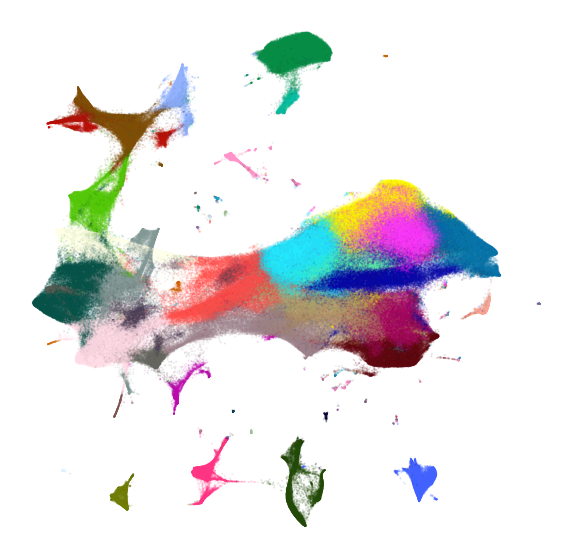

In [37]:
fig, ax = plt.subplots(figsize=(10, 10))
plot(embedding4 @ rotate(90), y, ax=ax)

## Comparison to UMAP

In [38]:
from umap import UMAP

/home/ppolicar/local/miniconda3/envs/tsne/lib/python3.7/site-packages/scikit_learn-0.21.0-py3.7-linux-x86_64.egg/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [39]:
umap = UMAP(n_neighbors=15, min_dist=0.1, random_state=1)

In [40]:
%time embedding_umap = umap.fit_transform(x)

CPU times: user 11h 1min 37s, sys: 18min 41s, total: 11h 20min 19s
Wall time: 1h 24min 29s


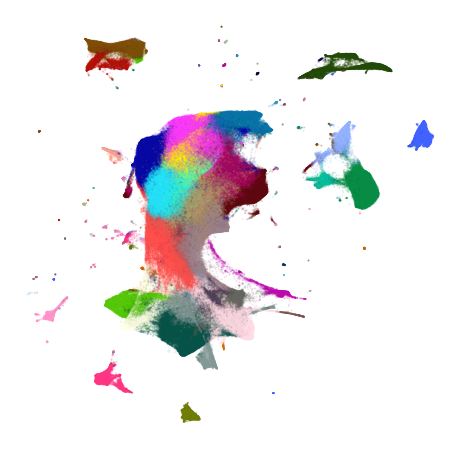

In [41]:
plot(embedding_umap, y)